# Non-linear tracking issue #111





## Setup

In [ ]:
%%capture
try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -q dynamax[notebooks]
    import dynamax

In [ ]:
from jax import numpy as jnp
from jax import random as jr
from matplotlib import pyplot as plt
import jax

from dynamax.utils.plotting import  plot_uncertainty_ellipses
from dynamax.nonlinear_gaussian_ssm import ParamsNLGSSM, NonlinearGaussianSSM, UKFHyperParams
from dynamax.nonlinear_gaussian_ssm import extended_kalman_filter as ekf
from dynamax.nonlinear_gaussian_ssm import unscented_kalman_filter as ukf


## Plotting different true states and observations


In [ ]:
import numpy as np
state_dim = 4
obs_dim = 2

source_0 = jnp.array([0.0, 0.0])
source_1 = jnp.array([2.0, 1.0])

# Dynamics function for the 4-dimensional state
f = lambda z: jnp.array([z[0] + .1 * z[2], z[1] + .1 * z[3],z[2],z[3]])

dt = 0.1
q_c1 =  0.1
q_c2 =  0.1
dynamics_covariance = jnp.array([[q_c1 * dt**3/3, 0, q_c1 * dt**2/2, 0],
                                [0, q_c2 * dt**3/3, 0, q_c2 * dt**2/2],
                                [q_c1 * dt**2/2, 0, q_c1 * dt, 0],
                                [0, q_c2 * dt**2/2, 0, q_c2 * dt]])

# emission function for 2d observation

h = lambda z: jnp.array([jnp.arctan2(z[1] - source_0[1], z[0] - source_0[0]),
                         jnp.arctan2(z[1] - source_1[1], z[0] - source_1[0])])

emission_sigma2 = 0.005
emission_covariance = jnp.eye(obs_dim) * emission_sigma2

# prior

initial_mean = jnp.array([1.5, 0.0, 0.0, 0.0])  # 4d initial state
initial_sigma2 = 1.0
initial_covariance = jnp.eye(state_dim) * initial_sigma2

params = ParamsNLGSSM(
    initial_mean = initial_mean,
    initial_covariance = initial_covariance,
    dynamics_function = f,
    dynamics_covariance = dynamics_covariance,
    emission_function = h,
    emission_covariance = emission_covariance
)

nlgssm = NonlinearGaussianSSM(state_dim, obs_dim)

key = jr.PRNGKey(0)
states, emissions = nlgssm.sample(params, key, num_timesteps=100)

theta_obs0 = emissions[:, 0]
theta_obs1 = emissions[:, 1]

theta_states0 =  jnp.arctan2(states[:, 1]- source_0[1], states[:, 0]- source_0[0])
theta_states1 =  jnp.arctan2(states[:, 1]- source_1[1], states[:, 0]- source_1[0])

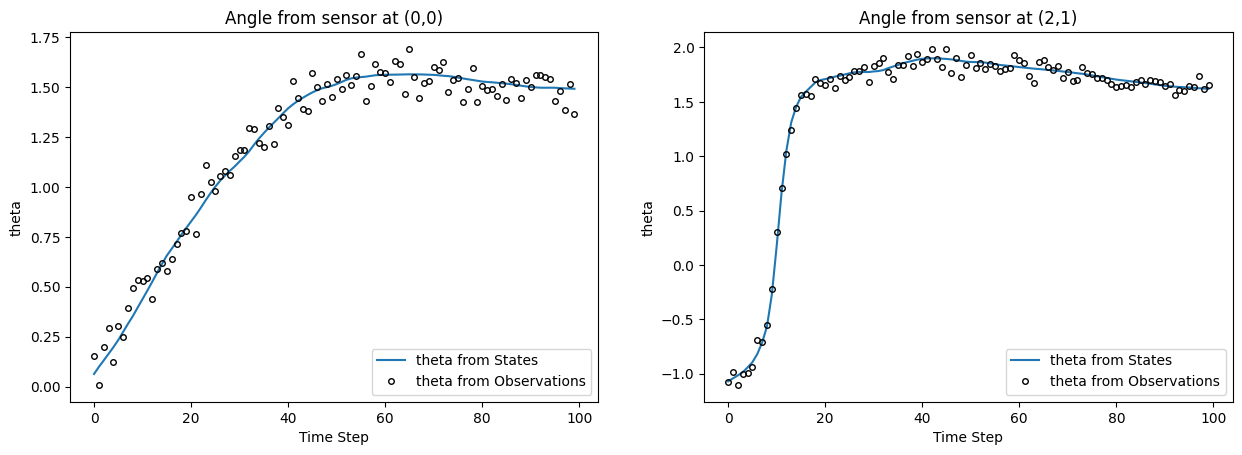

In [ ]:
fig, ax = plt.subplots(1,2)
# Plot theta from the states against theta from the observations
ax[0].plot(theta_states0, label="theta from States")
ax[0].plot(theta_obs0, 'ok', fillstyle="none", ms=4, label="theta from Observations")
ax[0].set_xlabel("Time Step")
ax[0].set_ylabel("theta")
ax[0].set_title("Angle from sensor at (0,0)")
ax[0].legend()

ax[1].plot(theta_states1, label="theta from States")
ax[1].plot(theta_obs1, 'ok', fillstyle="none", ms=4, label="theta from Observations")
ax[1].set_xlabel("Time Step")
ax[1].set_ylabel("theta")
ax[1].set_title("Angle from sensor at (2,1)")
ax[1].legend()
fig.set_figwidth(15)
plt.show()

# **Extended Kalman Filter**

Generally for non-linear systems the UKF is preffered beacuse the EKF linearizes the system while the way that the UKF is done is more suitable for non-linear systems

In [ ]:
fields = ["marginal_loglik", "filtered_means", "filtered_covariances"]
ekf_post = ekf(params, emissions, output_fields=fields)
ekf_means, ekf_covs = ekf_post.filtered_means, ekf_post.filtered_covariances

NameError: ignored

In [ ]:
fig, ax = plt.subplots(1,2)

# Plot theta from the states against theta from the observations
ekf_states_0 = jnp.arctan2(ekf_means[:, 1]- source_0[1], ekf_means[:, 0]- source_0[0])
ax[0].plot(ekf_states_0, label="theta from EKF",color='r')
ax[0].plot(theta_obs0, 'ok', fillstyle="none", ms=4, label="theta from Observations")
ax[0].set_xlabel("Time Step")
ax[0].set_ylabel("theta")
ax[0].set_title("EKF-filtered estimate of trajectory from sensor at (0,0)")
ax[0].legend()


# Plot theta from the states against theta from the observations
ekf_states_1 = jnp.arctan2(ekf_means[:, 1]- source_1[1], ekf_means[:, 0]- source_1[0])
ax[1].plot(ekf_states_1, label="theta from EKF",color='r')
ax[1].plot(theta_obs1, 'ok', fillstyle="none", ms=4, label="theta from Observations")
ax[1].set_xlabel("Time Step")
ax[1].set_ylabel("theta")
ax[1].set_title("EKF-filtered estimate of trajectory from sensor at (2,1)")
ax[1].legend()
fig.set_figwidth(15)
plt.show()

In [ ]:
#Animation
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Define the update function for the animation
def update(frame):
    ax[0].clear()
    ax[1].clear()

    # Plot theta from the states against theta from the observations for sensor at (0, 0)
    ekf_states_0 = jnp.arctan2(ekf_means[:frame+1, 1] - source_0[1], ekf_means[:frame+1, 0] - source_0[0])
    ax[0].plot(ekf_states_0, label="theta from EKF", color='r')
    ax[0].plot(theta_obs0[:frame+1], 'ok', fillstyle="none", ms=4, label="theta from Observations")
    ax[0].set_xlabel("Time Step")
    ax[0].set_ylabel("theta")
    ax[0].set_title("EKF-filtered estimate of trajectory from sensor at (0,0)")
    ax[0].set_xlim(-2, 105)  # Set x-axis limit from 0 to the final time step
    ax[0].set_ylim(-0.2,1.75)  # Set y-axis limit to the final y-axis range
    ax[0].legend(loc='lower right')
    ax[0].set_aspect("auto")  # Set the aspect ratio to "auto" or use a specific value

    # Plot theta from the states against theta from the observations for sensor at (2, 1)
    ekf_states_1 = jnp.arctan2(ekf_means[:frame+1, 1] - source_1[1], ekf_means[:frame+1, 0] - source_1[0])
    ax[1].plot(ekf_states_1, label="theta from EKF", color='r')
    ax[1].plot(theta_obs1[:frame+1], 'ok', fillstyle="none", ms=4, label="theta from Observations")
    ax[1].set_xlabel("Time Step")
    ax[1].set_ylabel("theta")
    ax[1].set_title("EKF-filtered estimate of trajectory from sensor at (2,1)")
    ax[1].set_xlim(-.2, 105)  # Set x-axis limit from 0 to the final time step
    ax[1].set_ylim(-1.2, 2.1)  # Set y-axis limit to the final y-axis range
    ax[1].legend(loc='lower right')
    ax[1].set_aspect("auto")  # Set the aspect ratio to "auto" or use a specific value

    fig.set_figwidth(15)

# Set the aspect ratio of the figure (width:height)
aspect_ratio = 16 / 9  # You can adjust this ratio to your preference
fig_width = 15
fig_height = fig_width / aspect_ratio
fig, ax = plt.subplots(1, 2, figsize=(fig_width, fig_height))

# Create the figure and axes
#fig, ax = plt.subplots(1, 2)

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(ekf_means), interval=200)

# Save the animation as an HTML video
ani.save("test_save.mp4",dpi=200,bitrate=-1,fps=15)

# Display the HTML video
HTML(ani.to_html5_video())
